### Example using degradation correction and calculating Fe18

Mind that the Fe18 calcualtion is only a "rough estimate" from [Del Zanna 2013](
https://www.aanda.org/articles/aa/pdf/2013/10/aa21653-13.pdf) with is using

I<sub>Fe18</sub> = I<sub>94</sub> - I<sub>171</sub> / 450. - I<sub>211</sub> / 120.


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.time as atime
import astropy.units as u
import scipy.io as io

import warnings
warnings.simplefilter('ignore')

from aiapy.calibrate import degradation
from aiapy.calibrate.util import get_correction_table

In [2]:
# Load in the correction table here to speed things up
# So I could loop over many times if I want to 
# Like Will does here https://aiapy.readthedocs.io/en/latest/generated/gallery/instrument_degradation.html#sphx-glr-generated-gallery-instrument-degradation-py
correction_table = get_correction_table()

In [3]:
# What channels and time working with?
channels = [94, 171, 211] * u.angstrom
time=atime.Time('2020-02-26T20:00:00', scale='utc')
print(channels)
print(time.isot)

[ 94. 171. 211.] Angstrom
2020-02-26T20:00:00.000


In [4]:
# Work out the degradation correction factor per channel for the chosen time
nc=len(channels)
degs=np.empty(nc)
for i in np.arange(nc):
    degs[i]=degradation(channels[i],time,correction_table=correction_table)
print(degs)

[0.99307497 0.77026654 0.4475236 ]


In [5]:
# Let's take some AIA data and correct it
# Here all the values are in DN/s/px
data=np.array([3.07,137.93,86.18])

# Correct for the degradation factors
data_cor=data/degs
print(data_cor)

# Work out the Fe18 for this data
data_fe18=data_cor[0] - data_cor[1]/450. - data_cor[2]/120.

print(data_fe18)

[  3.0914081  179.06788423 192.57085132]
1.0887223718630759


In [6]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~
# ~~~~~~~~~~~~~~~~~~~~~~~~~

In [7]:
# Load in the sswidl created temperature response file, 
# no degradation applied to these, i.e. no time_depend
trin=io.readsav('aia_resp_eve.dat')

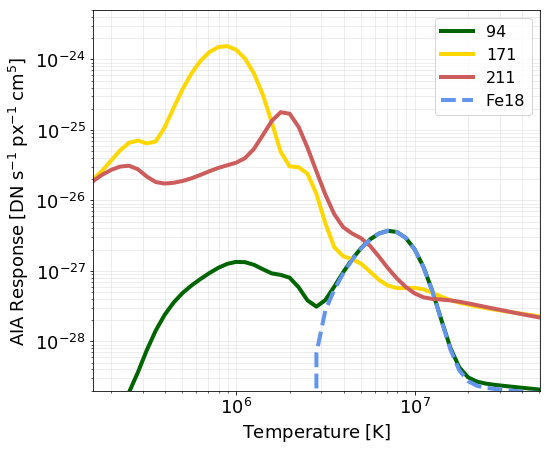

In [8]:
# Plot to check they look ok
logt=trin['logt']
tr094=trin['tr'][0]
tr171=trin['tr'][2]
tr211=trin['tr'][4]

trfe18=tr094 - tr171/450. - tr211/120.
trfe18[trfe18 < 0]=0

clrs=['darkgreen','darkcyan','gold','sienna','indianred','darkslateblue','cornflowerblue']

plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(8, 7))
plt.loglog(10**logt,tr094,label='94',color=clrs[0],lw=4)
plt.loglog(10**logt,tr171,label='171',color=clrs[2],lw=4)
plt.loglog(10**logt,tr211,label='211',color=clrs[4],lw=4)
plt.loglog(10**logt,trfe18,'--',label='Fe18',color=clrs[6],lw=4)
plt.xlabel('$\mathrm{Temperature\;[K]}$')
plt.ylabel('$\mathrm{AIA\;Response\;[DN\;s^{-1}\;px^{-1}\;cm^5]}$')
plt.ylim([2e-29,5e-24])
plt.xlim([10**5.2,10**7.7])
plt.legend(ncol=1,prop={'size': 16})
plt.grid(True,which='both',lw=0.5,color='gainsboro')
# plt.tight_layout(rect = [0, 0, 1, 1])
# plt.savefig('aia_resp_fe18.pdf',box_inches='tight')  
plt.show()

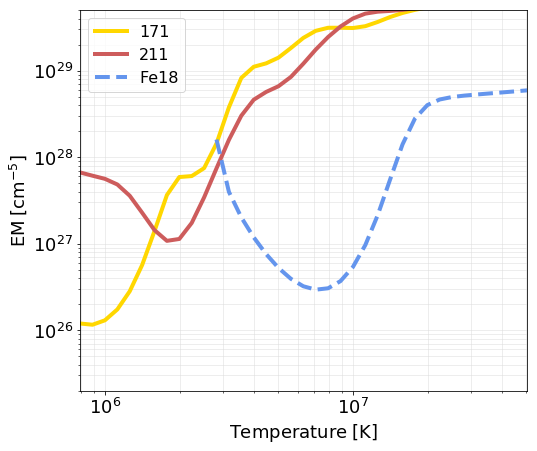

In [9]:
# Plot the EM Loci for the above data value

plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(8, 7))
# plt.loglog(10**logt,data_cor[0]/tr094,label='94',color=clrs[0],lw=4)
plt.loglog(10**logt,data_cor[1]/tr171,label='171',color=clrs[2],lw=4)
plt.loglog(10**logt,data_cor[2]/tr211,label='211',color=clrs[4],lw=4)
plt.loglog(10**logt,data_fe18/trfe18,'--',label='Fe18',color=clrs[6],lw=4)
plt.xlabel('$\mathrm{Temperature\;[K]}$')
plt.ylabel('$\mathrm{EM\;[cm^{-5}]}$')
plt.ylim([2e25,5e29])
plt.xlim([10**5.9,10**7.7])
plt.legend(ncol=1,prop={'size': 16})
plt.grid(True,which='both',lw=0.5,color='gainsboro') 
plt.show()

In [10]:
# Now let's assume we have a T and EM and work out the synthetic AIA flux
# Note that these are not meant to the flux values above
t0=4.2e6
logt0=np.log10(t0)
em0=1.5e45 #cm^-3
area=2.2e18 #cm^2

# work out the temperature response at this T for each channel
# interp in log space to get better result

resp094=10**np.interp(logt0,logt,np.log10(tr094))
respfe18=10**np.interp(logt0,logt,np.log10(trfe18))
print(resp094,respfe18)

print('Synthetic 94: ',resp094*em0/area)
print('Synthetic Fe18: ',respfe18*em0/area)

# These synthetic fluxes would be comparable to data that has been degradation corrected 
# as the responses used to produce them had no correction in them (assuming start of mission)


1.16745773934002e-27 1.1306796647982356e-27
Synthetic 94:  0.7959939131863774
Synthetic Fe18:  0.7709179532715243


In [11]:
# Now let's assume we have a two T and EM and work out the synthetic AIA flux
# Note that these are not meant to the flux values above
t0=4.2e6
logt0=np.log10(t0)
em0=1.5e45 #cm^-3
t1=1.2e6
logt1=np.log10(t1)
em1=8.5e46 #cm^-3
area=2.2e18 #cm^2

# work out the temperature response at this T for each channel
# interp in log space to get better result

resp094_0=10**np.interp(logt0,logt,np.log10(tr094))
respfe18_0=10**np.interp(logt0,logt,np.log10(trfe18))
resp094_1=10**np.interp(logt1,logt,np.log10(tr094))
respfe18_1=10**np.interp(logt1,logt,np.log10(trfe18))

print('Synthetic 94: ',resp094_0*em0/area + resp094_1*em1/area)
print('Synthetic Fe18: ',respfe18_0*em0/area + respfe18_1*em1/area)

Synthetic 94:  49.756427423247686
Synthetic Fe18:  0.7709179532715243
